## Import modules

In [1]:
import pdb
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
import nhanes as nhanes
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib notebook

import importlib
importlib.reload(nhanes)

<module 'nhanes' from '/Users/qiwenlyu/Development/Health-Analytics-Opportunistic/nhanes.py'>

## Settings

In [2]:
DATA_PATH = '/Users/qiwenlyu/Development/NHANES/'
DATASET = 'arthritis'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).

In [3]:
importlib.reload(nhanes)
ds = nhanes.Dataset(DATA_PATH)
ds.load_arthritis()
n_fe = ds.features.shape[1]
n_classes = 2

indx = np.argwhere(ds.targets != 3)
dataset_features = ds.features[indx.flatten()]
dataset_targets = ds.targets[indx.flatten()]

Processing: BPQ_I.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## PCA

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dataset_features)
print(pca.explained_variance_ratio_)  

[0.07047845 0.05052678]


## Train/Test Separation

In [5]:
#mutual information part
mutualInfo = mutual_info_classif(dataset_features,dataset_targets)
dataset_features = dataset_features.T[mutualInfo > 0].T
print(dataset_features.shape)
perm = np.random.permutation(dataset_targets.shape[0])
dataset_features = dataset_features[perm]
dataset_targets = dataset_targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]
    
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')

(5719, 125)


## Classification

In [6]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        # print('Confusion matrix, without normalization')
        pass
    # print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Function for all the testing

In [8]:
def result_print(model,features_trn,targets_trn,features_tst):
    model.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    print('accu_tst_RFC', accu)

    predict_proba = clf.predict_proba(features_tst)

    cnf_matrix = confusion_matrix(targets_tst, preds_tst)
    fpr, tpr, _ = roc_curve(targets_tst, predict_proba[:,1])
    plot_roc(fpr, tpr)
    plot_confusion_matrix(cnf_matrix, classes=["CT","RA"], normalize=True, title='Normalized confusion matrix')
    print(classification_report(targets_tst, preds_tst))

In [9]:
def result_print_without(model,features_trn,targets_trn,features_tst):
    model.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    print('accu_tst_RFC', accu)
    cnf_matrix = confusion_matrix(targets_tst, preds_tst)
    plot_confusion_matrix(cnf_matrix, classes=["CT","RA"], normalize=True, title='Normalized confusion matrix')
    print(classification_report(targets_tst, preds_tst))

## KNeighbors

accu_tst_RFC 0.8381112984822934


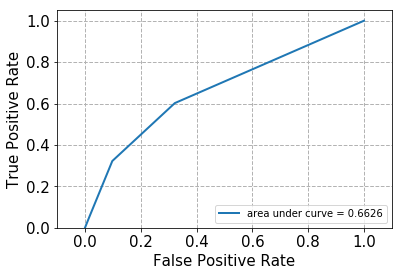

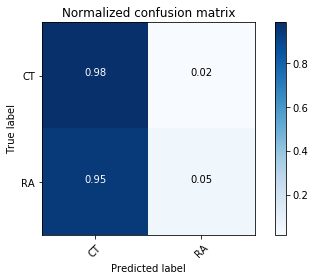

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       500
         1.0       0.38      0.05      0.09        93

   micro avg       0.84      0.84      0.84       593
   macro avg       0.62      0.52      0.50       593
weighted avg       0.78      0.84      0.78       593



In [23]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
result_print(clf,features_trn,targets_trn,features_tst)

## Decision Tree

accu_tst_RFC 0.7959527824620574


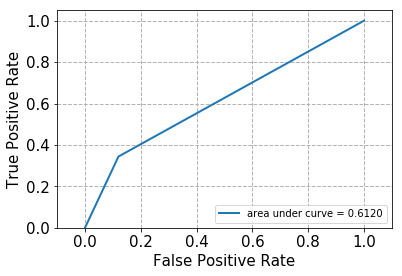

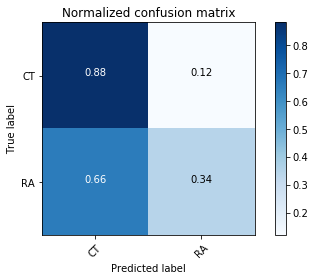

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       500
         1.0       0.35      0.34      0.35        93

   micro avg       0.80      0.80      0.80       593
   macro avg       0.61      0.61      0.61       593
weighted avg       0.80      0.80      0.80       593



In [10]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
result_print(clf,features_trn,targets_trn,features_tst)

## Neural Network

accu_tst_RFC 0.8313659359190556


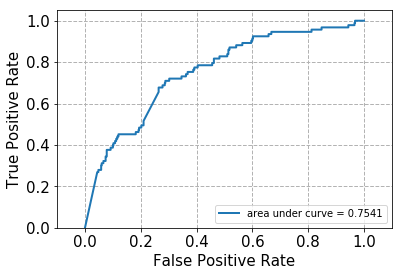

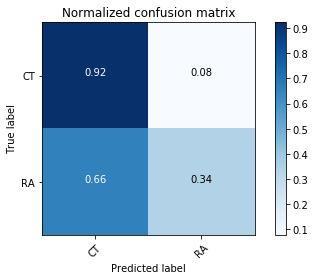

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       500
         1.0       0.45      0.34      0.39        93

   micro avg       0.83      0.83      0.83       593
   macro avg       0.67      0.63      0.65       593
weighted avg       0.82      0.83      0.82       593



In [11]:
#neural network
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
result_print(clf,features_trn,targets_trn,features_tst)

## AdaBoostClassifier

accu_tst_RFC 0.8313659359190556


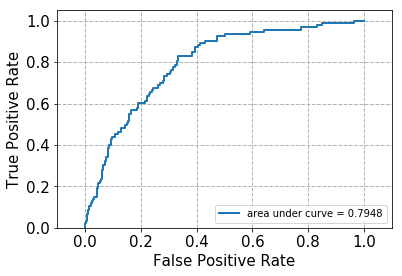

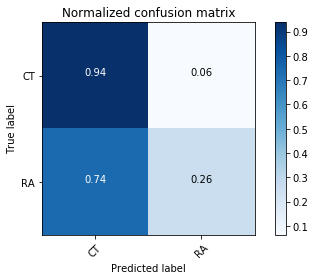

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       500
         1.0       0.44      0.26      0.32        93

   micro avg       0.83      0.83      0.83       593
   macro avg       0.65      0.60      0.61       593
weighted avg       0.80      0.83      0.81       593



In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
result_print(clf,features_trn,targets_trn,features_tst)

accu_tst_RFC 0.851602023608769


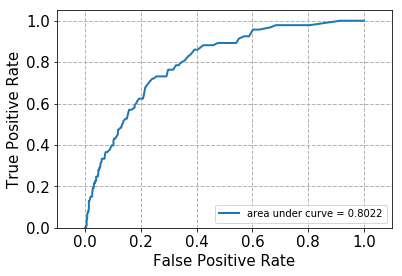

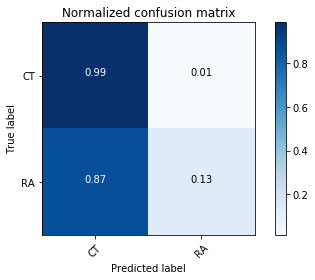

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       500
         1.0       0.63      0.13      0.21        93

   micro avg       0.85      0.85      0.85       593
   macro avg       0.75      0.56      0.57       593
weighted avg       0.82      0.85      0.81       593



In [13]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=0,class_weight='balanced')
result_print(clf,features_trn,targets_trn,features_tst)

accu_tst_RFC 0.8263069139966274


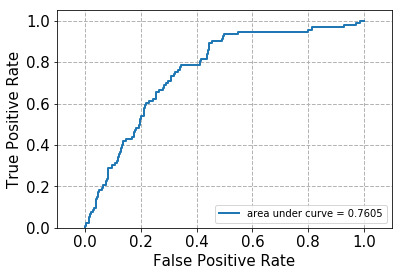

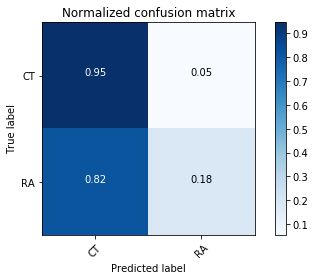

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       500
         1.0       0.39      0.18      0.25        93

   micro avg       0.83      0.83      0.83       593
   macro avg       0.62      0.56      0.57       593
weighted avg       0.79      0.83      0.80       593



In [14]:
from sklearn import ensemble
from sklearn import datasets

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}
clf = ensemble.GradientBoostingClassifier(**original_params)
result_print(clf,features_trn,targets_trn,features_tst)

## Random Forest

accu_tst_RFC 0.8431703204047217


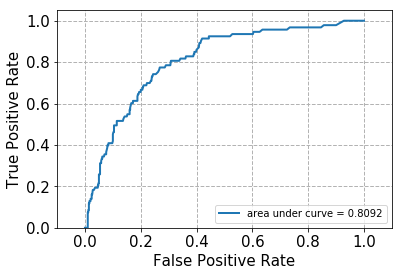

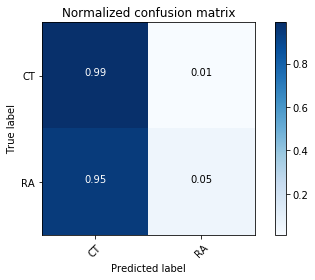

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91       500
         1.0       0.50      0.05      0.10        93

   micro avg       0.84      0.84      0.84       593
   macro avg       0.67      0.52      0.51       593
weighted avg       0.79      0.84      0.79       593



In [15]:
clf = RandomForestClassifier(n_estimators=1000,class_weight='balanced')
result_print(clf,features_trn,targets_trn,features_tst)

## SVC

accu_tst_RFC 0.7436762225969646


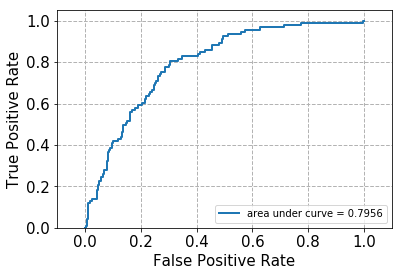

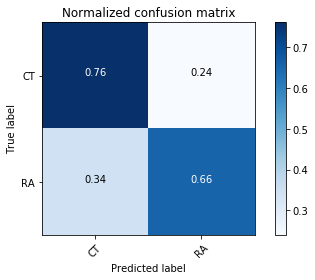

              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83       500
         1.0       0.34      0.66      0.45        93

   micro avg       0.74      0.74      0.74       593
   macro avg       0.63      0.71      0.64       593
weighted avg       0.83      0.74      0.77       593



In [16]:
clf = SVC(gamma='auto',class_weight='balanced',probability=True)
result_print(clf,features_trn,targets_trn,features_tst)

## Logistic Regression

/anaconda3/envs/health/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


accu_tst_RFC 0.7284991568296796


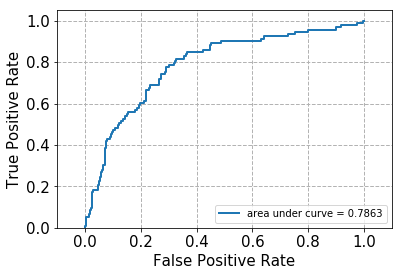

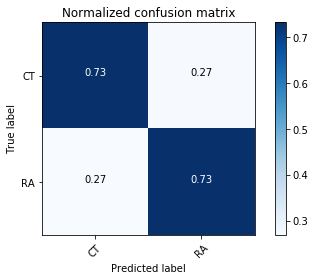

              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82       500
         1.0       0.33      0.73      0.46        93

   micro avg       0.73      0.73      0.73       593
   macro avg       0.63      0.73      0.64       593
weighted avg       0.84      0.73      0.76       593



In [17]:
clf = LogisticRegression(solver='lbfgs', max_iter=200,class_weight='balanced')
result_print(clf,features_trn,targets_trn,features_tst)

## KMeans

accu_tst_RFC 0.3288364249578415


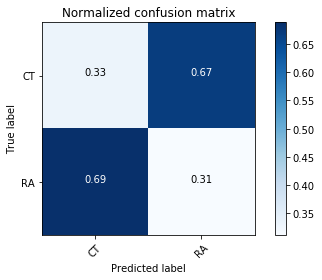

              precision    recall  f1-score   support

         0.0       0.72      0.33      0.45       500
         1.0       0.08      0.31      0.13        93

   micro avg       0.33      0.33      0.33       593
   macro avg       0.40      0.32      0.29       593
weighted avg       0.62      0.33      0.40       593



In [18]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
result_print_without(clf,features_trn,targets_trn,features_tst)